In [1]:
%load_ext autoreload
%autoreload 2

import ipyparallel
import brian2.numpy_ as np
import brian2.only as bb
from brian2 import ms, second, Hz, mV, pA, nS, pF
from matplotlib import pyplot as plt
from tqdm import tqdm
import assemblyseq.assemblyseq as asq

from assemblyseq import plotter
import assemblyseq.calc_spikes as cs


rc = ipyparallel.Client()
ipyparallel.use_cloudpickle()


faster_run = True
dview = rc[:]


In [2]:
config = {'Ne': 20000, 'Ni': 5000, 'cp_ee': .01, 'cp_ie': .01, 'cp_ei': 0.01, 'cp_ii': .01,
              'n_ass': 10, 's_ass': 500, 'pr': .15, 'pf': .03, 'symmetric_sequence': True, 'p_rev': .03,
              'g_ee': 0.1 * nS, 'g_ie': 0.1 * nS, 'g_ei': 0.4 * nS, 'g_ii': 0.4 * nS, 'n_sim': 0}

In [3]:
configs = []
for i, pf in enumerate([0.01, 0.03, 0.1]):
    cf = config.copy()
    cf['pf'] = pf
    cf['n_sim'] = i
    configs.append(cf)

In [4]:
@dview.parallel(block=True)
def network_sim(config):
    import brian2.numpy_ as np
    import brian2.only as bb
    import brian2.core
    from brian2 import ms, second, Hz, mV, pA, nS, pF
    from collections import defaultdict

    i = config['n_sim']
    faster_run = True
    if faster_run:
        bb.set_device('cpp_standalone', directory='PETH_standalone_'+str(i), build_on_run=False)
        brian2.core.tracking.InstanceFollower.instance_sets = defaultdict(brian2.core.tracking.InstanceTrackerSet)

    # bb.start_scope()
    if faster_run:
        bb.get_device().reinit()
        bb.get_device().activate(build_on_run=False, directory='PETH_standalone_'+str(i))

    import assemblyseq.assemblyseq as asq


    nn = asq.Nets(config)

    nn.generate_ps_assemblies('gen_no_overlap')
    nn.set_net_connectivity()

    nn.set_spike_monitor()
    nn.set_rate_monitor()

    for gr_num in range(nn.n_ass):
        gr = nn.p_ass_index[0][gr_num]
        t_inp = (20.55 + gr_num * .1) * second
        nn.set_noisy_input(gr, t_inp, sigma=0 * ms)

    nn.set_syn_input(nn.p_ass_index[0][0], np.arange(26, 31,1))
    nn.balance(10 * second, 5.)
    nn.balance(10 * second, .1)
    nn.balance(5 * second, .01)
    nn.run_sim(12*second)
    
    # nn.Pe.I -= .0 * pA

    if faster_run:
        bb.get_device().build(directory='PETH_standalone_'+str(i), compile=True, run=True, debug=False)
    return nn.get_results()
    #return nn

In [5]:
nns = network_sim.map(configs)

In [11]:
nns[0]

(0, 100)

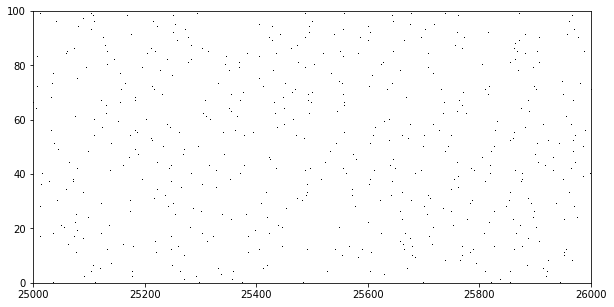

In [22]:
nnr = nns[0]

plt.figure(figsize=(10, 5))
plt.plot(nnr.mon_spike_e.t/ms, nnr.mon_spike_e.i, ',k')
#plt.xlim([45800, 46200])
plt.xlim([25000, 26000])
plt.ylim([0, 100])

<Figure size 720x360 with 0 Axes>

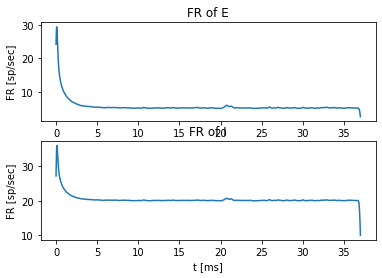

In [23]:
plt.figure(figsize=(10, 5))
plotter.plot_pop_fr(nnr)

In [24]:
spikes = cs.get_spike_times_ps(nnr, n_ps=0, frac=0.05)

si, st = zip(*spikes)

(25500, 36000)

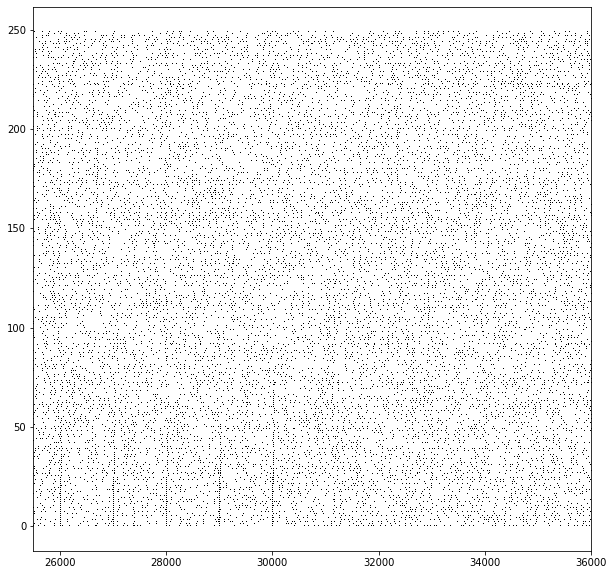

In [26]:
plt.figure(figsize=(10, 10))
plt.plot(st/ms, si, ',k')
plt.xlim([25500, 36000])